In [1]:
%run task_setup.ipynb

Foundation: 2.11.029
Transition: 3.02.026


-------------------------
## Build Flu Risk raw synthetic file

In [2]:
builder = SyntheticBuilder.from_env('flu_risk')

In [3]:
tools = builder.intent_model

In [4]:
builder.pm.reset_intents()
builder.pm_persist()

In [5]:
sample_size = 1000

**get the data from the members dataset on s3**

In [6]:
# Set up the members data
factory_members = "s3://project-hadron-cs-repo/factory/healthcare/members/factory_transition_members_dataset_v05.parquet"
builder.add_connector_uri(connector_name='members', uri=factory_members)

In [7]:
# pass an empty dataframe  of sample_size
df = tools.canonical2dict(method='@empty', size=sample_size)

# Get the columns from the Members connector and concat it to the empty df
df = builder.tools.model_concat(df, other='members', as_rows=False, headers=['member_id', 'state', 'age', 'channel_pref'], column_name='member_reference')
builder.add_column_description(column_name='member_reference', description="member reference data taken from the members distribution")

**get the data from the insurance dataset on s3**

In [8]:
# Set up the members data
factory_members = "s3://project-hadron-cs-repo/factory/healthcare/members/factory_transition_ins_members_dataset_v05.parquet"
builder.add_connector_uri(connector_name='ins_members', uri=factory_members)

In [9]:
# Get the columns from the Members file
df = builder.tools.model_merge(df, other='ins_members', on='member_id',  headers=['ins_icd_10_code'], column_name='claims_reference')
builder.add_column_description(column_name='claims_reference', description="insurance claims data for the ICD codes")

--------------------------

In [10]:
builder.canonical_report(df)

,Attributes (4),dType,%_Null,%_Dom,Count,Unique,Observations
0,age,int64,0.0%,4.2%,1000,65,max=91 | min=21 | mean=39.17 | dominant=30
1,ins_icd_10_code,category,0.0%,55.1%,1000,3,Sample: 0 | Z23 | Z28
2,member_id,int64,0.0%,0.1%,1000,1000,"max=999585789 | min=100854999 | mean=556217335.54 | dominant=[100854999, 101322999]"
3,state,string,0.0%,19.2%,1000,14,Sample: California | New York | Ohio | Wisconsin | Missouri


--------------------------

In [11]:
# add todays timestamp
df['date'] = builder.tools.get_datetime(start=-14, until=-13, size=sample_size, date_format="%Y-%m-%d", ignore_time=True, column_name='date')
builder.add_column_description(column_name='date', description="The date of the flu risk score")

In [12]:
# conditional latent privilage for age under 40
selection = [builder.tools.select2dict(column='age', condition='@<=40')]

action = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.1, precision=1, relative_freq=[20, 1])
default = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.2, precision=1, relative_freq=[3, 20, 1])

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=-1)
builder.add_column_description(column_name='age_privilege', description="set privilege for under 40 with reduced risk with default zero privilage")

In [13]:
# conditional latent privilage for age over 75
selection = [builder.tools.select2dict(column='age', condition='@>75')]

action = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.3, precision=1, relative_freq=[1, 99, 10])
default = builder.tools.action2dict(method='@header', header='age_privilege')

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=-1)
builder.add_column_description(column_name='age_privilege', description="set zero privilage for most over 75")

--------------------------

---------------------
### Create the risk score normal distribution

In [14]:
df['flu_risk_score'] = builder.tools.get_dist_bounded_normal(mean=0.55, std=0.2, lower=0.1, upper=1, precision=3, size=sample_size, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="A generated flu risk score with a bound normal distribution wth a mean of 0.55 and std of 0.2")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

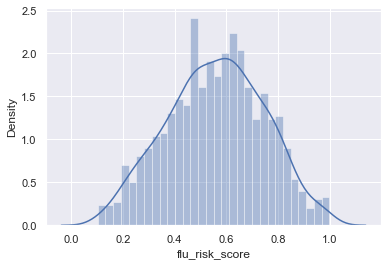

In [15]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

---------------------
### Resample Normal Distribution for those with previous flu shots under 40

In [16]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@<40', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.1, std=0.1, lower=0.001, upper=0.4, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and under 40 with a bound normal distribution, mean of 0.1 and std of 0.1 with an upper bound of 0.4")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

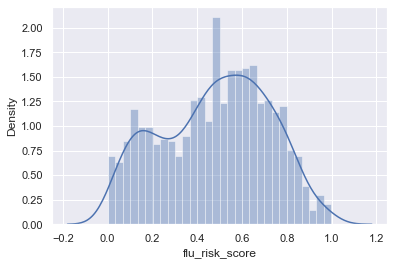

In [17]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

---------------------
### Resample Normal Distribution for those with previous flu shots 40 to under 65

In [18]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@>=40', logic='AND'),
             tools.select2dict(column='age', condition='@<65', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.25, std=0.1, lower=0.001, upper=0.6, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and 40 <= age < 65, with a bound normal distribution, mean of 0.25 and std of 0.1 with an upper bound of 0.6")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

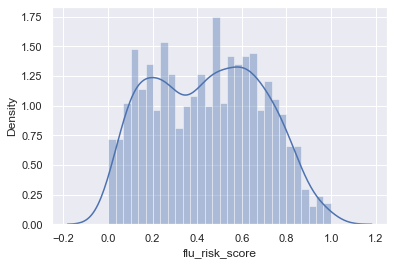

In [19]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

---------------------
### Resample Normal Distribution for those with previous flu shots 65+

In [20]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@>=65', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.4, std=0.15, lower=0.1, upper=0.9, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and 65 + with a bound normal distribution, mean of 0.4 and std of 0.15 with an upper bound of 0.9")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

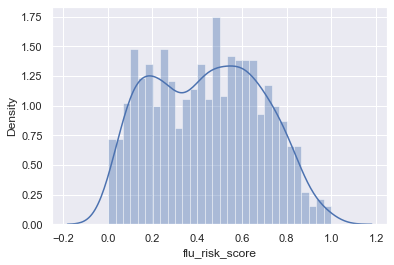

In [21]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

---------------------
### Adjust risk based on the Latent age privilage

In [22]:
# adjust flu risk according to age privilage
selection = [tools.select2dict(column='flu_risk_score', condition="@>0.1"),
             tools.select2dict(column='age', condition="@>40", logic='OR')]

action = tools.action2dict(method='correlate_aggregate', headers=['flu_risk_score', 'age_privilege'], agg='sum', precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="add age_privilege to the risk score to adjust for the privilage of age")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

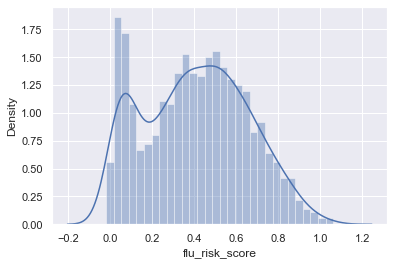

In [23]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

In [24]:
# adjust for the upper bound range
selection = [tools.select2dict(column='flu_risk_score', condition="@>=1")]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.9, std=0.02, lower=0.8, upper=0.998, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default , column_name='flu_risk_score', intent_order=-1)

In [25]:
# adjust for the lower bound range
selection = [tools.select2dict(column='flu_risk_score', condition="@<=0")]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.1, std=0.02, lower=0.01, upper=0.2, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default , column_name='flu_risk_score', intent_order=-1)

<AxesSubplot:xlabel='flu_risk_score', ylabel='Density'>

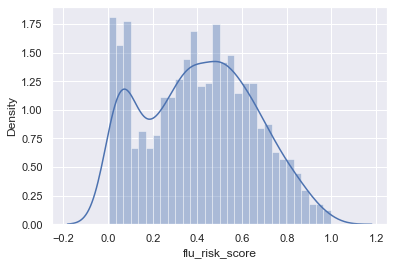

In [26]:
sns.set()
sns.distplot(df['flu_risk_score'], bins=30)

In [27]:
builder.run_component_pipeline(size=sample_size)

In [28]:
builder.report_column_catalog()

,column_name,description
0,age_privilege,"set privilege for under 40 with reduced risk with default zero privilage, set zero privilage for most over 75"
1,claims_reference,insurance claims data for the ICD codes
2,date,The date of the flu risk score
3,flu_risk_score,"A generated flu risk score with a bound normal distribution wth a mean of 0.55 and std of 0.2, normally distribute those with a flue-shot and under 40 with a bound normal distribution, mean of 0.1 and std of 0.1 with an upper bound of 0.4, normally distribute those with a flue-shot and 40 <= age < 65, with a bound normal distribution, mean of 0.25 and std of 0.1 with an upper bound of 0.6, normally distribute those with a flue-shot and 65 + with a bound normal distribution, mean of 0.4 and std of 0.15 with an upper bound of 0.9, add age_privilege to the risk score to adjust for the privilage of age"
4,member_reference,member reference data taken from the members distribution


-------------------------
## Flu Risk Score Transition

In [29]:
tr = Transition.from_env('flu_risk')

In [30]:
tr.pm.reset_intents()
tr.pm_persist()

In [31]:
df = tr.load_source_canonical()

In [32]:
df = tr.intent_model.auto_clean_header(df)
df = tr.intent_model.to_float_type(df, headers='flu_risk_score', precision=3)
df = tr.intent_model.to_select(df, headers=['member_id', 'date', 'flu_risk_score'])

In [33]:
tr.run_component_pipeline()

In [34]:
tr.canonical_report(tr.load_persist_canonical())

,Attributes (3),dType,%_Null,%_Dom,Count,Unique,Observations
0,date,object,0.0%,100.0%,1000,1,Sample: 2021-02-21
1,flu_risk_score,float64,0.0%,0.6%,1000,599,"max=0.994 | min=0.001 | mean=0.4 | dominant=[0.451, 0.509]"
2,member_id,int64,0.0%,0.1%,1000,1000,"max=999585789 | min=100854999 | mean=556217335.54 | dominant=[100854999, 101322999]"
